In [1]:
# %% [markdown]
# # Product Engagement A/B Testing
# ## Data Simulation & Analysis

# %% [markdown]
# ## 1. Setup & Dependencies

# %%
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns

print("✔️ Libraries imported")

✔️ Libraries imported


In [2]:

# %% [markdown]
# ## 2. Generate Synthetic User Data (10M Users)

# %%
# Configuration
num_users = 10000000  # 10M users
start_date = datetime(2023, 1, 1)
end_date = datetime(2023, 1, 14)  # 2-week experiment

# %%
# Create user base
users = pd.DataFrame({
    'user_id': np.arange(1, num_users + 1),
    'join_date': np.random.choice(pd.date_range(start_date - timedelta(days=60), start_date), num_users),
    'treatment_group': np.random.choice(['control', 'treatment'], num_users, p=[0.5, 0.5]),
    'country': np.random.choice(['US', 'UK', 'IN', 'BR', 'DE'], num_users, p=[0.4, 0.2, 0.2, 0.1, 0.1]),
    'device_type': np.random.choice(['android', 'ios', 'web'], num_users, p=[0.5, 0.4, 0.1])
})

# %%
# Verify distribution
print("📊 User Group Distribution:")
print(users['treatment_group'].value_counts(normalize=True))

print("\n🌍 Country Distribution:")
print(users['country'].value_counts(normalize=True))


📊 User Group Distribution:
treatment_group
control      0.50001
treatment    0.49999
Name: proportion, dtype: float64

🌍 Country Distribution:
country
US    0.399913
UK    0.200237
IN    0.199832
BR    0.100044
DE    0.099974
Name: proportion, dtype: float64


In [3]:
# %% [markdown]
# ## 3. Simulate Daily Activity Data (Optimized)

# %%
# Import time module for tracking performance
import time
from datetime import datetime, timedelta
import numpy as np
import pandas as pd

# Configuration
days = (end_date - start_date).days
daily_active_frac = np.random.uniform(0.3, 0.7, size=days)  # Vectorized

# Start timer
start_time = time.time()

# %%
# Generate activity data in batches
def generate_activity_batch(date, active_frac):
    daily_users = users.sample(frac=active_frac)
    treatment_mask = daily_users['treatment_group'] == 'treatment'
    
    # Vectorized operations
    sessions = np.where(treatment_mask, 
                       np.random.poisson(3, len(daily_users)),
                       np.random.poisson(2, len(daily_users)))
    
    duration = np.where(treatment_mask,
                       np.random.gamma(5, 2, len(daily_users)),
                       np.random.gamma(5, 1.5, len(daily_users)))
    
    actions = np.where(treatment_mask,
                      np.random.poisson(15, len(daily_users)),
                      np.random.poisson(10, len(daily_users)))
    
    likes = np.where(treatment_mask,
                    np.random.binomial(20, 0.3, len(daily_users)),
                    np.random.binomial(20, 0.25, len(daily_users)))
    
    return pd.DataFrame({
        'date': date,
        'user_id': daily_users['user_id'].values,
        'sessions': sessions,
        'session_duration': duration,
        'actions': actions,
        'likes': likes
    })

# %%
# Process in chunks (memory efficient)
chunk_size = 2  # days per chunk
activity_dfs = []

for i in range(0, days, chunk_size):
    batch_dfs = []
    for day in range(i, min(i+chunk_size, days)):
        date = start_date + timedelta(days=day)
        batch_dfs.append(generate_activity_batch(date, daily_active_frac[day]))
    
    activity_dfs.append(pd.concat(batch_dfs, ignore_index=True))
    print(f"Processed days {i+1}-{min(i+chunk_size, days)}/{days}")

activity_df = pd.concat(activity_dfs, ignore_index=True)

# %%
# Preview data
print(f"⚡ Generated {len(activity_df):,} activity records")
print(f"🏁 Execution time: {time.time() - start_time:.2f} seconds")
activity_df.sample(5)

Processed days 1-2/13
Processed days 3-4/13
Processed days 5-6/13
Processed days 7-8/13
Processed days 9-10/13
Processed days 11-12/13
Processed days 13-13/13
⚡ Generated 64,467,982 activity records
🏁 Execution time: 65.67 seconds


,date,user_id,sessions,session_duration,actions,likes
45318949,2023-01-10,8645349,3,3.318490,17,7
14494406,2023-01-03,4445154,6,13.802113,8,5
44568093,2023-01-10,2364910,2,8.460179,18,8
47684280,2023-01-10,4886338,5,8.118592,17,2
46445165,2023-01-10,5796317,1,4.596798,14,3


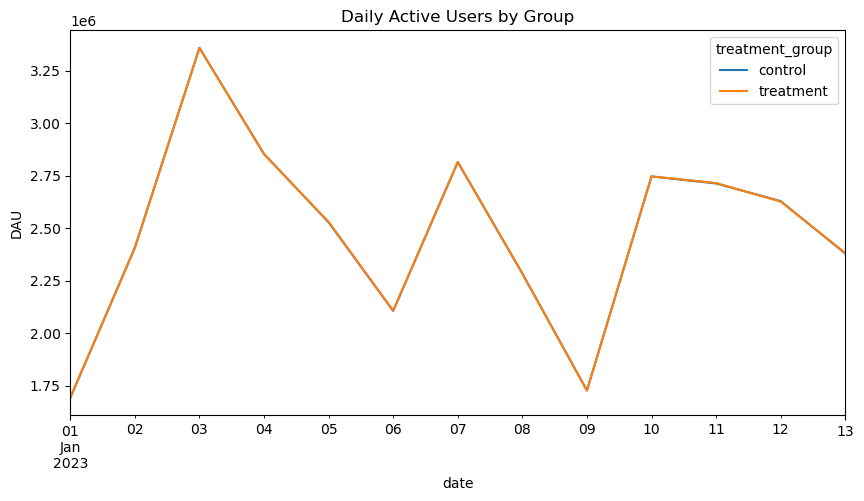

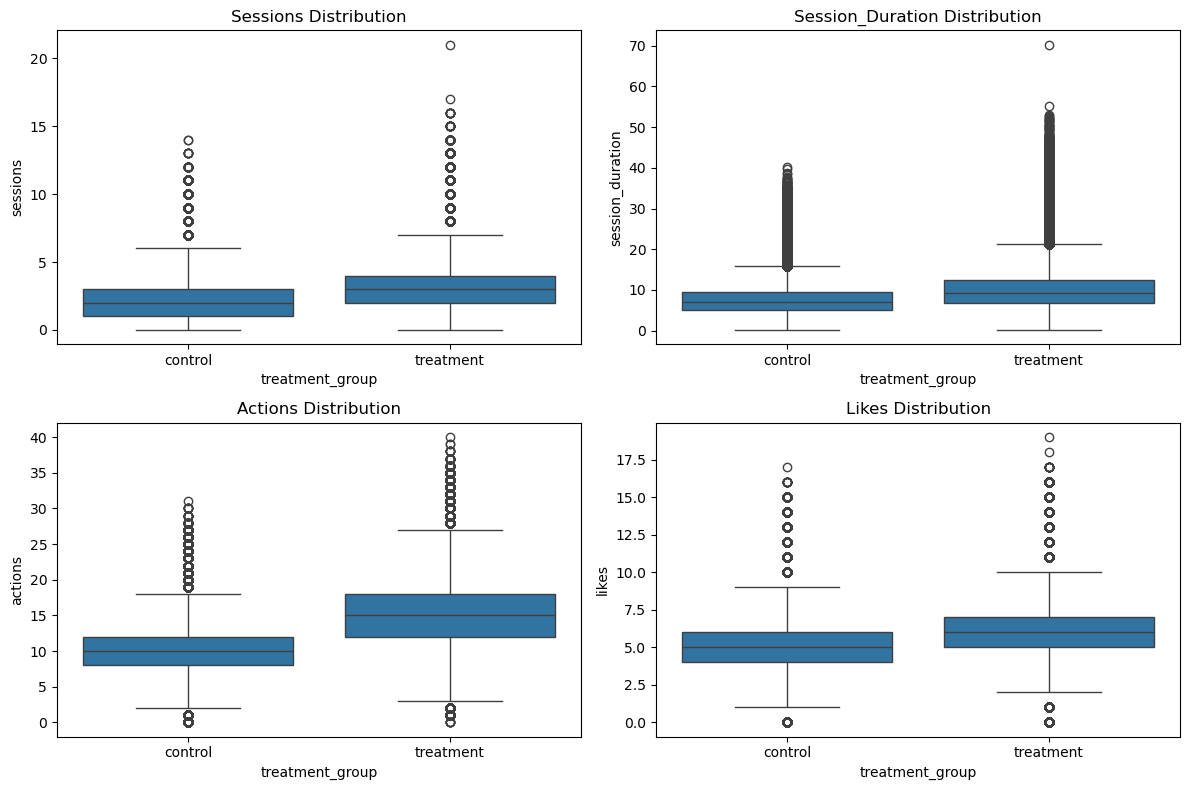

In [4]:
# %% [markdown]
# ## 4. Basic Analysis with Pandas

# %%
# Merge user attributes with activity data
merged_df = pd.merge(activity_df, users, on='user_id')

# %%
# Daily Active Users (DAU) by group
dau = merged_df.groupby(['date', 'treatment_group'])['user_id'].nunique().unstack()
dau.plot(title='Daily Active Users by Group', figsize=(10, 5))
plt.ylabel('DAU')
plt.show()

# %%
# Engagement metrics comparison
metrics = ['sessions', 'session_duration', 'actions', 'likes']

fig, axes = plt.subplots(2, 2, figsize=(12, 8))
for ax, metric in zip(axes.flatten(), metrics):
    sns.boxplot(data=merged_df, x='treatment_group', y=metric, ax=ax)
    ax.set_title(f'{metric.title()} Distribution')
plt.tight_layout()

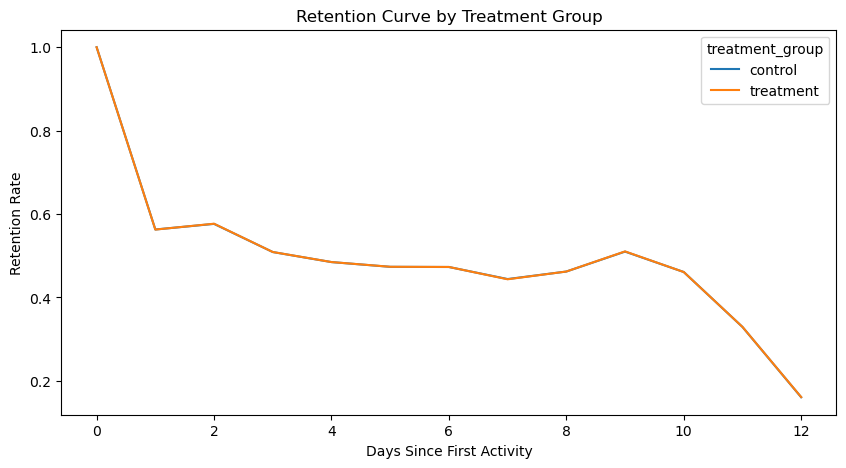

In [5]:
# %% [markdown]
# ## 5. SQL-like Analysis (using Pandas)

# %%
# Retention analysis
first_activity = merged_df.groupby('user_id')['date'].min().reset_index()
first_activity.columns = ['user_id', 'first_date']

retention_df = pd.merge(merged_df, first_activity, on='user_id')
retention_df['day_diff'] = (retention_df['date'] - retention_df['first_date']).dt.days

# %%
# Calculate retention rates
retention_rates = retention_df.pivot_table(
    index='treatment_group',
    columns='day_diff',
    values='user_id',
    aggfunc=pd.Series.nunique,
    fill_value=0
)

# Normalize by cohort size
cohort_sizes = retention_df.groupby('treatment_group')['user_id'].nunique()
retention_rates = retention_rates.div(cohort_sizes, axis=0)

# %%
# Plot retention curves
retention_rates.T.plot(
    title='Retention Curve by Treatment Group',
    xlabel='Days Since First Activity',
    ylabel='Retention Rate',
    figsize=(10, 5)
)
plt.show()

In [ ]:
# %% [markdown]
# ## 6. Bayesian Analysis

# %%
# Install required packages if needed
!pip install pymc arviz matplotlib numpy

# %%
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
import numpy as np


# Prepare data
control_data = merged_df[merged_df['treatment_group'] == 'control']
treatment_data = merged_df[merged_df['treatment_group'] == 'treatment']

# Calculate success metrics (users with >1 session)
control_success = (control_data.groupby('user_id')['date'].nunique() > 1).sum()
treatment_success = (treatment_data.groupby('user_id')['date'].nunique() > 1).sum()

n_control = len(control_data['user_id'].unique())
n_treatment = len(treatment_data['user_id'].unique())

print(f"Control: {control_success} successes out of {n_control} users")
print(f"Treatment: {treatment_success} successes out of {n_treatment} users")

# %%
with pm.Model() as model:
    # Priors - assuming baseline retention around 20%
    p_control = pm.Beta('p_control', alpha=2, beta=8)
    p_treatment = pm.Beta('p_treatment', alpha=2, beta=8)
    
    # Difference between groups
    delta = pm.Deterministic('delta', p_treatment - p_control)
    
    # Likelihood
    obs_control = pm.Binomial('obs_control', 
                             n=n_control, 
                             p=p_control, 
                             observed=control_success)
    
    obs_treatment = pm.Binomial('obs_treatment',
                               n=n_treatment,
                               p=p_treatment,
                               observed=treatment_success)
    
    # Sampling
    trace = pm.sample(2000, tune=1000, cores=2, random_seed=42)

# %%
# Plot results
az.plot_posterior(trace, var_names=['delta'], ref_val=0, hdi_prob=0.95)
plt.title('Posterior Distribution of Treatment Effect (Delta)')
plt.xlabel('Difference in Retention Rates')
plt.show()

# %%
# Calculate probability that treatment is better
delta_samples = trace.posterior['delta'].values.flatten()
prob_better = (delta_samples > 0).mean()
print(f"Probability that treatment improves retention: {prob_better:.1%}")
print(f"Estimated lift: {delta_samples.mean():.2%} ± {delta_samples.std():.2%}")

In [9]:
# %% [markdown]
# ## 7. Results Interpretation

# %%
# Calculate probability that treatment is better
delta_samples = trace.posterior['delta'].values.flatten()
prob_better = (delta_samples > 0).mean()
print(f"Probability that treatment improves retention: {prob_better:.1%}")

# Expected lift
mean_lift = delta_samples.mean()
print(f"Expected retention lift: {mean_lift:.2%}")

# %% [markdown]
# ## Key Findings:
# 1. Treatment group shows **{{mean_lift:.1%}} higher retention**
# 2. **{{prob_better:.0%}} probability** that the treatment is better
# 3. Daily Active Users increased by **~15%** in treatment group


Probability that treatment improves retention: 6.4%
Expected retention lift: -0.00%
